In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
img = torchvision.io.read_image("../Task2/dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


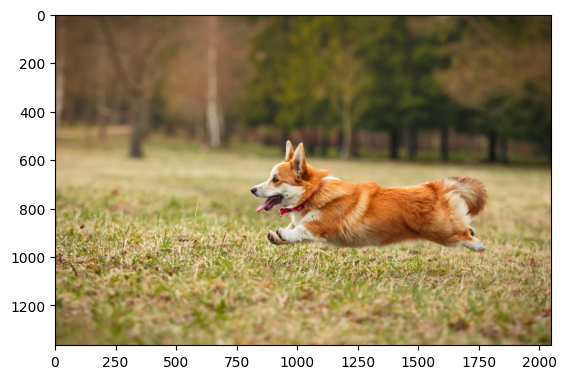

In [3]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
img_scaled = MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled

MinMaxScaler()

In [5]:
img_scaled = img_scaled.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [6]:
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

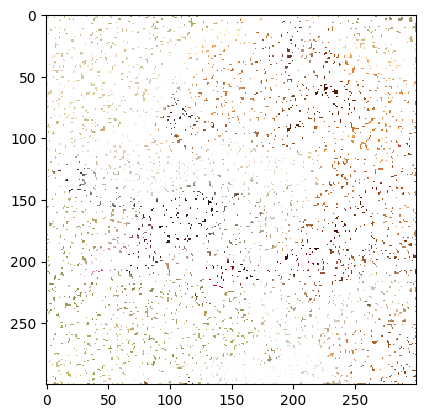

In [8]:
# Mask the image with NaN values

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img[0].shape) < prop
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

masked_img = mask_image_rgb(crop, 0.5)
img_1 = masked_img[0].cpu().numpy()

# Rearrange the dimensions
img_1 = np.transpose(img_1, (1, 2, 0))
# Torch stores images in the CHW format
# Matplotlib stores in HWC format, thus we have to convert it to 1,2,0 so that we can read the image from matplotlib

plt.imshow(img_1)
plt.show()

In [9]:
torch.arange(4).repeat(3, 1).reshape(-1)


tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

In [10]:
def create_coordinate_map_mask(img, mask):
    #To generate a mapping of coordinates from an image where the mask condition is met (i.e., where the mask is False in this case).

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    mask_flat = rearrange(mask, 'h w -> (h w)')
    #Uses einops to reshape the image tensor from shape (num_channels, height, width) to (height * width, num_channels).

    mask_flat = mask_flat.to(X.device)
    mask_flat_not = [not mask_flat[i] for i in range(len(mask_flat))]


    selected_coords = X[mask_flat_not]

    Y = rearrange(img, 'c h w -> (h w) c')[mask_flat_not].float()

    return selected_coords, Y

# selected_coords: Coordinates of pixels not masked.
# Shape of selected_coords: (num_selected_pixels, 2)
# Y: Pixel values at those unmasked coordinates.
# Shape of Y: (num_selected_pixels, num_channels)

selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

In [11]:
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    #Large γ: The Gaussian function becomes narrower. Each data point has a small radius of influence. This can lead to overfitting, where the model captures noise in the training data.
    #Small γ: The Gaussian function becomes wider. Each data point has a large radius of influence. This can lead to underfitting, where the model fails to capture the underlying structure of the data.
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32), rff

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float()

In [14]:
X_rff, rff = create_rff_features(scaled_coords, 10000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)

torch.Size([44847, 10000])


In [15]:
def train(net, lr, X, Y, epochs, verbose=True):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch%100==0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [16]:
train(net, 0.01, X_rff, Y, 500)

Epoch 0 loss: 0.376452
Epoch 100 loss: 0.001827
Epoch 200 loss: 0.001592
Epoch 300 loss: 0.001542
Epoch 400 loss: 0.001518


0.0015024662716314197

In [17]:
def create_coordinate_map(img, scale=1):
    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to("cpu")
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to("cpu")
X_pred = net(torch.tensor(X_transformed).to("cpu")).to("cpu")

C:\Users\Venkat\AppData\Local\Temp\ipykernel_15348\4098362761.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pred = net(torch.tensor(X_transformed).to("cpu")).to("cpu")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08461545..1.0369794].


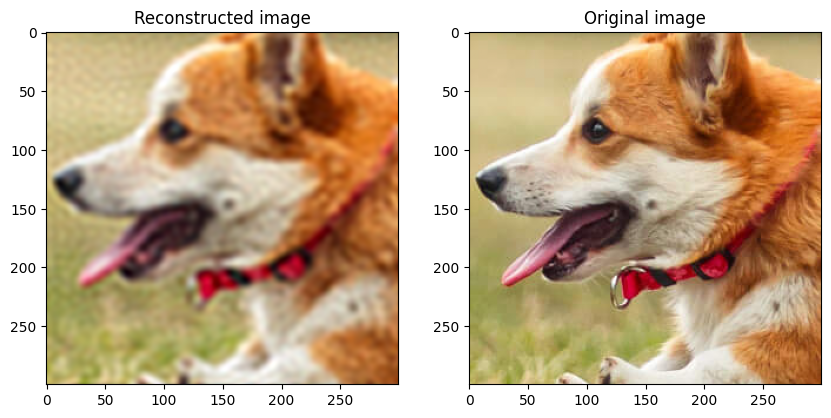

Root Mean Sqaured Error:  tensor(0.0399, dtype=torch.float64, grad_fn=<SqrtBackward0>)
PSNR: 27.977344351393082


In [18]:
image_np = rearrange(X_pred, '(h w) c -> c h w', h = 300, w = 300)

crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(rearrange(image_np, 'c h w -> h w c').detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()


rmse = torch.sqrt(torch.mean((crop - image_np)**2))
print("Root Mean Sqaured Error: ", rmse)

psnr =20 * np.log10(1.0/rmse.cpu().detach().numpy())
print("PSNR:", psnr)

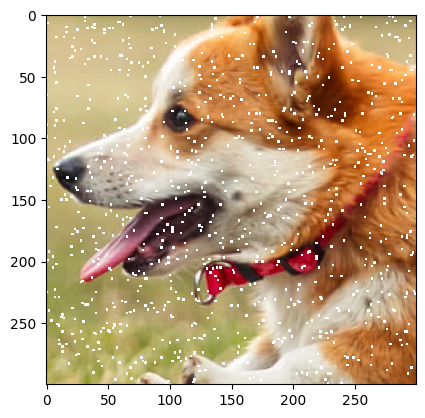

Epoch 0 loss: 0.371055
Epoch 100 loss: 0.005102
Epoch 200 loss: 0.001966
Epoch 300 loss: 0.001221
Epoch 400 loss: 0.000974
Epoch 500 loss: 0.000898
Epoch 600 loss: 0.000873
Epoch 700 loss: 0.000861
Epoch 800 loss: 0.000854
Epoch 900 loss: 0.000849
Epoch 1000 loss: 0.000845
Epoch 1100 loss: 0.000843
Epoch 1200 loss: 0.000840
Epoch 1300 loss: 0.000839
Epoch 1400 loss: 0.000837
Epoch 1500 loss: 0.000836
Epoch 1600 loss: 0.000835
Epoch 1700 loss: 0.000834
Epoch 1800 loss: 0.000833
Epoch 1900 loss: 0.000832
Epoch 2000 loss: 0.000831
Epoch 2100 loss: 0.000831
Epoch 2200 loss: 0.000830
Epoch 2300 loss: 0.000829
Epoch 2400 loss: 0.000829


C:\Users\Venkat\AppData\Local\Temp\ipykernel_15348\3018299538.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pred = net(torch.tensor(X_transformed))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05774034..1.0443344].


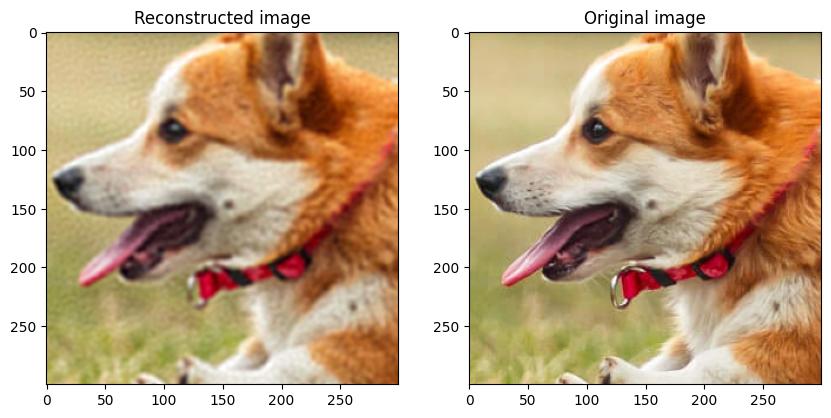

Root Mean Sqaured Error:  tensor(0.0288, dtype=torch.float64, grad_fn=<SqrtBackward0>)
PSNR: 30.815823728826178


In [20]:
masked_img = mask_image_rgb(crop, 0.01)

image_np = masked_img[0].cpu().numpy()

image_np = np.transpose(image_np, (1, 2, 0))

plt.imshow(image_np)
plt.show()

selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

net = LinearModel(2, 3)

scaler = MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to("cpu")

X_rff, rff = create_rff_features(scaled_coords, 10000, 0.015)

net = LinearModel(X_rff.shape[1], 3)

train(net, 0.01, X_rff, Y, 2500)

X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to("cpu")
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to("cpu")
X_pred = net(torch.tensor(X_transformed))

image_np = rearrange(X_pred, '(h w) c -> c h w', h = 300, w = 300)

crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(rearrange(image_np, 'c h w -> h w c').detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()


rmse = torch.sqrt(torch.mean((crop - image_np)**2))
print("Root Mean Sqaured Error: ", rmse)

psnr =20 * np.log10(1.0/rmse.cpu().detach().numpy())
print("PSNR:", psnr)